# Generate random observation data for 7DT broad-band (gri)
- Gregory S.H. Paek
- 22.09.29
- medium-band, ugri, BVRI


In [1]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import multiprocessing
from itertools import repeat

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

## Useful functions

In [3]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
# lsstbdw = bdwtbl['bandwidth'][bdwtbl['group']
#
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth
# dptbl = get_7dt_depth(exptime=180)
dptbl = get_7dt_broadband_depth(exptime=180)

In [4]:
magoffset = -4.3

In [5]:
knsp = '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle0_synphot_sdss.ecsv'
intbl = ascii.read(knsp)
intbl[10:25]

t,g,i,r,u
d,mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64
0.297,-13.751,-13.189,-13.390,-14.057
0.324,-13.778,-13.231,-13.432,-14.023
0.354,-13.788,-13.277,-13.464,-13.948
0.386,-13.777,-13.307,-13.492,-13.813
0.42,-13.749,-13.332,-13.531,-13.602
0.459,-13.688,-13.363,-13.571,-13.298
0.5,-13.580,-13.407,-13.615,-12.902
0.545,-13.412,-13.469,-13.655,-12.452


- Synphot Table

In [6]:
def extract_param_kn_sim_cube(knsp):
	part = os.path.basename(knsp).split('_')

	if part[1] == 'TP':
		dshape = 'toroidal'
	elif part[1] == 'TS':
		dshape = 'spherical'
	else:
		dshape = ''

	#	Latitude
	if part[5] == 'wind1':
		lat = 'Axial'
	elif part[5] == 'wind2':
		lat = 'Edge'
	else:
		lat = ''

	#	Ejecta mass for low-Ye [solar mass]
	md = float(part[7].replace('md', ''))

	#	Ejecta velocity for low-Ye [N*c]
	vd = float(part[8].replace('vd', ''))

	#	Ejecta mass for high-Ye [solar mass]
	mw = float(part[9].replace('mw', ''))

	#	Ejecta velocity for high-Ye [N*c]
	vw = float(part[10].replace('vw', ''))

	#	Angle
	angle = float(part[11].replace('angle', ''))

	return dshape, lat, md, vd, mw, vw, angle

In [7]:
dshape, lat, md, vd, mw, vw, angle = extract_param_kn_sim_cube(knsp)
print(dshape, lat, md, vd, mw, vw, angle)

spherical Edge 0.1 0.3 0.1 0.3 0.0


- Depth Table

In [8]:
dptbl

index,name,center_wavelength,fwhm,min_wavelength,max_wavelength,noise_countrate,surface_brightness,5sigma_depth
,,Angstrom,Angstrom,Angstrom,Angstrom,electron / s,mag / arcsec2,mag
int64,str1,float64,float64,float64,float64,float64,float64,float64
0,u,3573.89,250.0,3448.89,3698.89,0.103991,20.943,21.027
1,g,4723.55,250.0,4598.55,4848.55,1.666986,21.948,22.032
2,r,6202.46,250.0,6077.46,6327.46,1.331368,21.500,21.585
3,i,7522.43,250.0,7397.43,7647.43,0.751287,20.656,20.740


In [9]:
def calc_snr(m, ul, sigma=5):
	snr = sigma*10**((ul-m)/5)
	return snr

def convert_snr2magerr(snr):
	merr = 2.5*np.log10(1+1/snr)
	return merr

def calc_GaussianFraction(seeing, optfactor=0.6731, path_plot=None):
	import numpy as np
	import matplotlib.pyplot as plt
	from scipy.special import erf

	# seeing, optfactor= 1.5, 0.6731

	mu = 0.0
	# sigma = fwhm_seeing/2.355
	fwhm2sigma = seeing*2.355
	# optfactor = 0.6731
	sigma = fwhm2sigma*optfactor

	x = np.linspace(-8, 8, 1000)
	y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x-mu)**2 / (2 * sigma**2))
	y_cum = 0.5 * (1 + erf((x - mu)/(np.sqrt(2 * sigma**2))))

	indx_aperture = np.where(
		(x>-sigma*optfactor) &
		(x<+sigma*optfactor)
	)
	xaper = x[indx_aperture]
	yaper = y[indx_aperture]

	frac = np.sum(yaper)/np.sum(y) 
	# print(np.sum(y), np.sum(yaper), frac)

	if path_plot != None:
		plt.plot(x, y, alpha=0.5, label=f'PDF of N(0, {sigma:1.3f})', lw=5)
		plt.plot(xaper, yaper, alpha=1.0, label=f'Aperture ({frac*1e2:.1f}%)', lw=5,)
		plt.xlabel('x', fontsize=20)
		plt.ylabel('f(x)', fontsize=20)
		plt.legend(loc='lower center', fontsize=14)
		# plt.show()
		plt.savefig(path_plot, overwrite=True)
	else:
		pass

	return frac

def add_noise(mu, sigma, nseed, n=10, path_plot=None):
	"""
	mu, sigma = 17.5, 0.1
	n = 10
	"""
	from scipy.stats import norm
	import numpy as np
	
	try:
		x = np.arange(mu-sigma*n, mu+sigma*n, sigma*1e-3)
		y = norm(mu, sigma).pdf(x)

		if path_plot != None:
			resultlist = []
			for i in range(10000):
				xobs = np.random.choice(x, p=y/np.sum(y))
				# print(xobs)
				resultlist.append(xobs)
			plt.axvspan(xmin=mu-sigma, xmax=mu+sigma, alpha=0.5, color='tomato',)
			plt.axvline(x=mu, ls='--', alpha=1.0, color='tomato', lw=3)
			plt.plot(x, y, lw=3, alpha=0.75, color='grey')
			plt.hist(resultlist, lw=3, alpha=0.75, color='k', histtype='step', density=True)
			plt.xlabel(r'$\rm m_{obs}$')
			plt.plot(x, y)
			plt.savefig(path_plot, overwrite=True)
		else:
			pass
		#	more complicated choice with the fixed random seed
		np.random.seed(int((nseed+1)+(mu*1e2)))
		return np.random.choice(x, p=y/np.sum(y))
	except:
		# print('Something goes wrong (add_noise function)')
		return None

In [10]:
#	Setting
niteration = 10
d = 40*u.Mpc
aperfrac = calc_GaussianFraction(seeing=1.5, optfactor=0.6731, path_plot=None)
times = np.unique(intbl['t'])
bfilterlist = [filte for filte in intbl.keys() if filte != 't']
# bfilterlist = ['g', 'r', 'i']

t0 = time.time()
tablelist = []
for nseed in range(niteration):

	outbl = Table()
	# outbl.meta['distance'] = d
	outbl['seed'] = [nseed]*len(times)
	outbl['t'] = times

	for filte in bfilterlist:
		depth = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
		# outbl.meta[f'depth_{filte}'] = depth

		outbl[f'magabs_{filte}'] = (intbl[filte]+magoffset)*u.ABmag
		outbl[f'magapp_{filte}'] = convert_abs2app(outbl[f'magabs_{filte}'], d.to(u.pc).value)*u.ABmag
		outbl[f'snr_{filte}'] = calc_snr(outbl[f'magapp_{filte}'], depth.value)*aperfrac
		outbl[f'magerr_{filte}'] = convert_snr2magerr(outbl[f'snr_{filte}'])*u.ABmag
		outbl[f'magobs_{filte}'] = [add_noise(mu=m, sigma=merr, nseed=nseed, n=10, path_plot=None) for m, merr in zip(outbl[f'magapp_{filte}'], outbl[f'magerr_{filte}'])]*u.ABmag
		
		outbl[f'fnu_{filte}'] = outbl[f'magapp_{filte}'].to(u.uJy)
		outbl[f'fnuobs_{filte}'] = outbl[f'magobs_{filte}'].to(u.uJy)
		outbl[f'fnuerr_{filte}'] = outbl[f'fnu_{filte}']/outbl[f'snr_{filte}']

		outbl[f'detection_{filte}'] = [True if m<=depth.value else False for m in outbl[f'magobs_{filte}']]

		outbl[f'magabs_{filte}'].format = '1.3f'
		outbl[f'magapp_{filte}'].format = '1.3f'
		outbl[f'magerr_{filte}'].format = '1.3f'
		outbl[f'magobs_{filte}'].format = '1.3f'
		outbl[f'fnu_{filte}'].format = '1.3f'
		outbl[f'fnuobs_{filte}'].format = '1.3f'
		outbl[f'fnuerr_{filte}'].format = '1.3f'
		outbl[f'snr_{filte}'].format = '1.3f'

	#	Table of results --> tabelist
	tablelist.append(outbl)

comtbl = vstack(tablelist)
comtbl.meta['name'] = os.path.basename(knsp)
for filte in bfilterlist: comtbl.meta[f'depth_{filte}'] = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
comtbl.meta['distance'] = d
comtbl.meta['dshape'] = dshape
comtbl.meta['lat'] = lat
comtbl.meta['md'] = md
comtbl.meta['vd'] = vd
comtbl.meta['mw'] = mw
comtbl.meta['vw'] = vw
comtbl.meta['angle'] = angle

delt = time.time() - t0
print(f"Time ({niteration} iter.) : {delt:1.3f} sec")
print(f"Time/iteration  : {delt/niteration:1.3f} sec/iter.")

Time (10 iter.) : 1.177 sec
Time/iteration  : 0.118 sec/iter.


- Expected time

In [11]:
ndelt = delt/niteration
for nn in np.arange(0, 6+1, 1):
	print(f"10^{nn} iter. : {(ndelt*10**nn)/60:1.3f} min")

10^0 iter. : 0.002 min
10^1 iter. : 0.020 min
10^2 iter. : 0.196 min
10^3 iter. : 1.962 min
10^4 iter. : 19.620 min
10^5 iter. : 196.200 min
10^6 iter. : 1961.997 min


In [12]:
comtbl[10:30]
# comtbl.meta

seed,t,magabs_g,magapp_g,snr_g,magerr_g,magobs_g,fnu_g,fnuobs_g,fnuerr_g,detection_g,magabs_i,magapp_i,snr_i,magerr_i,magobs_i,fnu_i,fnuobs_i,fnuerr_i,detection_i,magabs_r,magapp_r,snr_r,magerr_r,magobs_r,fnu_r,fnuobs_r,fnuerr_r,detection_r,magabs_u,magapp_u,snr_u,magerr_u,magobs_u,fnu_u,fnuobs_u,fnuerr_u,detection_u
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool
0,0.297,-18.051,14.959,64.917,0.017,14.946,3770.117,3814.524,58.076,True,-17.489,15.522,27.638,0.039,15.538,2245.750,2212.475,81.256,True,-17.690,15.321,44.729,0.024,15.348,2702.312,2634.816,60.415,True,-18.357,14.654,47.040,0.023,14.647,4995.510,5023.752,106.197,True
0,0.324,-18.078,14.932,65.727,0.016,14.929,3864.827,3875.931,58.801,True,-17.531,15.479,28.188,0.038,15.536,2335.985,2216.969,82.873,True,-17.732,15.279,45.600,0.024,15.321,2808.573,2702.309,61.592,True,-18.323,14.687,46.320,0.023,14.670,4843.814,4918.565,104.572,True
0,0.354,-18.088,14.923,66.017,0.016,14.912,3898.938,3938.055,59.060,True,-17.577,15.433,28.788,0.037,15.428,2436.530,2446.952,84.637,True,-17.764,15.246,46.296,0.023,15.264,2894.922,2848.162,62.531,True,-18.248,14.763,44.732,0.024,14.752,4517.334,4563.915,100.986,True
0,0.386,-18.077,14.933,65.702,0.016,14.930,3861.840,3872.940,58.778,True,-17.607,15.403,29.187,0.037,15.375,2504.631,2570.363,85.812,True,-17.792,15.219,46.880,0.023,15.224,2968.419,2954.792,63.320,True,-18.113,14.897,42.044,0.026,14.867,3990.708,4102.563,94.918,True
0,0.42,-18.049,14.962,64.842,0.017,14.964,3761.398,3753.405,58.009,True,-17.632,15.379,29.518,0.036,15.310,2561.684,2728.721,86.784,True,-17.831,15.179,47.738,0.023,15.158,3078.148,3138.330,64.480,True,-17.902,15.109,38.147,0.028,15.106,3285.277,3293.193,86.121,True
0,0.459,-17.988,15.023,63.045,0.017,15.014,3555.800,3585.131,56.401,True,-17.663,15.347,29.951,0.036,15.395,2637.459,2523.822,88.058,True,-17.871,15.139,48.632,0.022,15.172,3194.556,3098.561,65.688,True,-17.598,15.412,33.173,0.032,15.394,2484.418,2526.159,74.892,True
0,0.5,-17.880,15.130,60.002,0.018,15.157,3220.852,3142.030,53.679,True,-17.707,15.303,30.559,0.035,15.301,2745.532,2751.816,89.844,True,-17.915,15.095,49.620,0.022,15.073,3325.644,3393.681,67.022,True,-17.202,15.808,27.639,0.039,15.763,1724.625,1797.981,62.398,True
0,0.545,-17.712,15.298,55.529,0.019,15.286,2758.574,2790.913,49.678,True,-17.769,15.242,31.441,0.034,15.268,2906.264,2837.745,92.437,True,-17.955,15.055,50.539,0.021,15.066,3449.926,3415.490,68.263,True,-16.752,16.258,22.467,0.047,16.203,1139.599,1199.427,50.722,True


Text(0.5, 1.0, 't=0.125 days')

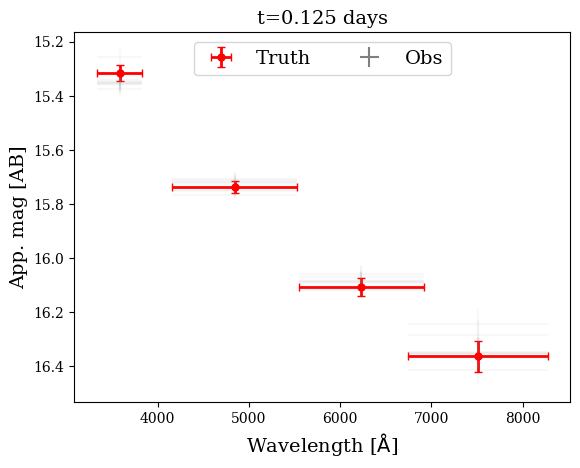

In [13]:
t = times[0]
# seeds = np.arange(0, 99+1, 1)
seeds = np.arange(0, 9, 1)
nseed = len(seeds)
# colors = makeSpecColors(nseed)

for ii, nseed in enumerate(seeds):
	magobslist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magobs' in key]
	magerrlist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magerr' in key]
	if ii == 0:
		magapplist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magapp' in key]
		plt.errorbar(slam, magapplist, xerr=sbdw/2, yerr=magerrlist, marker='.', ms=10, capsize=3, elinewidth=2, c='red', label='Truth', ls='None', alpha=1.0)
	else:
		pass

	plt.errorbar(slam, magobslist, xerr=sbdw/2, yerr=magerrlist, ls='None', alpha=0.05, c='grey',)

xl, xr = plt.xlim()
yl, yu = plt.ylim()

plt.errorbar(0, 0, xerr=0, yerr=0, ls='None', alpha=1.0, c='grey', label='Obs')

plt.legend(loc='upper center', ncol=4, fontsize=14)
plt.xlim([xl, xr])
plt.ylim([yu, yl])
plt.xlabel(r'Wavelength [$\rm \AA$]', fontsize=14)
plt.ylabel('App. mag [AB]', fontsize=14)
plt.title(f't={t:1.3f} days')

# Iteration

- Setting

In [14]:
path_result = "../5.result/kn_sim_cube_obs"
if ~os.path.exists(path_result): os.system(f"mkdir {path_result}")

mkdir: ../5.result/kn_sim_cube_obs: File exists


In [15]:
niteration = int(1e2)
d = 40*u.Mpc
aperfrac = calc_GaussianFraction(seeing=1.5, optfactor=0.6731, path_plot=None)

In [16]:
knsplist = sorted(glob.glob("../3.table/kn_sim_cube_synphot/Run_*_synphot_sdss.ecsv"))
knsplist[:5]

['../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle150_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle180_synphot_sdss.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle30_synphot_sdss.ecsv']

In [17]:
# ii = 0
# #	Single kilonova spectrum
# knsp = knsplist[ii]

# for ii, knsp in enumerate(knsplist[:5]):
# 	#	New kilonova file name
# 	nknsp = f"{path_result}/{os.path.basename(knsp).replace('.ecsv', f'_obs_d{int(d.value)}_iter{niteration}.sdss.ecsv')}"
# 	nknplot = f"{path_result}/{os.path.basename(nknsp).replace('.ecsv', '.sdss.png')}"
# 	# print(nknsp, nknplot)
# 	if not(os.path.exists(nknsp)) or not(os.path.exists(nknplot)):

# 		# print(f"[{ii+1}/{len(knsplist)}] {os.path.basename(knsp)}", end='\r')
# 		intbl = ascii.read(knsp)
# 		#	Extract parameters
# 		dshape, lat, md, vd, mw, vw, angle = extract_param_kn_sim_cube(knsp)
# 		# print(dshape, lat, md, vd, mw, vw, angle)

# 		#	Setting
# 		times = np.unique(intbl['t'])
# 		bfilterlist = [filte for filte in intbl.keys() if filte != 't']
# 		# bfilterlist = ['g', 'r', 'i']


# 		t0 = time.time()
# 		tablelist = []
# 		for nseed in range(niteration):
# 			print(f"[{ii+1}/{len(knsplist)}] {int(1e2*(nseed+1)/niteration)}%", end='\r')

# 			outbl = Table()
# 			outbl['seed'] = [nseed]*len(times)
# 			outbl['t'] = times

# 			for filte in bfilterlist:
# 				depth = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
# 				# outbl.meta[f'depth_{filte}'] = depth

# 				outbl[f'magabs_{filte}'] = (intbl[filte]+magoffset)*u.ABmag
# 				outbl[f'magapp_{filte}'] = convert_abs2app(outbl[f'magabs_{filte}'], d.to(u.pc).value)*u.ABmag
# 				outbl[f'snr_{filte}'] = calc_snr(outbl[f'magapp_{filte}'], depth.value)*aperfrac
# 				outbl[f'magerr_{filte}'] = convert_snr2magerr(outbl[f'snr_{filte}'])*u.ABmag
# 				outbl[f'magobs_{filte}'] = [add_noise(mu=m, sigma=merr, nseed=nseed, n=10, path_plot=None) for m, merr in zip(outbl[f'magapp_{filte}'], outbl[f'magerr_{filte}'])]*u.ABmag
				
# 				outbl[f'fnu_{filte}'] = outbl[f'magapp_{filte}'].to(u.uJy)
# 				outbl[f'fnuobs_{filte}'] = outbl[f'magobs_{filte}'].to(u.uJy)
# 				outbl[f'fnuerr_{filte}'] = outbl[f'fnu_{filte}']/outbl[f'snr_{filte}']

# 				outbl[f'detection_{filte}'] = [True if m<=depth.value else False for m in outbl[f'magobs_{filte}']]

# 				outbl[f'magabs_{filte}'].format = '1.3f'
# 				outbl[f'magapp_{filte}'].format = '1.3f'
# 				outbl[f'magerr_{filte}'].format = '1.3f'
# 				outbl[f'magobs_{filte}'].format = '1.3f'
# 				outbl[f'fnu_{filte}'].format = '1.3f'
# 				outbl[f'fnuobs_{filte}'].format = '1.3f'
# 				outbl[f'fnuerr_{filte}'].format = '1.3f'
# 				outbl[f'snr_{filte}'].format = '1.3f'

# 			#	Table of results --> tabelist
# 			tablelist.append(outbl)

# 		#	Stack tables and Put header
# 		comtbl = vstack(tablelist)
# 		comtbl.meta['name'] = os.path.basename(knsp)
# 		for filte in bfilterlist: comtbl.meta[f'depth_{filte}'] = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
# 		comtbl.meta['distance'] = d
# 		comtbl.meta['dshape'] = dshape
# 		comtbl.meta['lat'] = lat
# 		comtbl.meta['md'] = md
# 		comtbl.meta['vd'] = vd
# 		comtbl.meta['mw'] = mw
# 		comtbl.meta['vw'] = vw
# 		comtbl.meta['angle'] = angle

# 		comtbl.write(nknsp, format='ascii.ecsv', overwrite=True)

# 		#	Plot
# 		seeds = np.arange(0, niteration, 1)
# 		nseed = len(seeds)
# 		# colors = makeSpecColors(nseed)

# 		plt.close('all')
# 		fig = plt.figure(figsize=(20, 4))
# 		for jj, tt in enumerate(np.arange(8, 32+8, 8)):
# 			t = times[tt]
# 			plt.subplot(1, 4, jj+1)

# 			for ii, seed in enumerate(seeds):
# 				magobslist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==seed)].item() for key in comtbl.keys() if 'magobs' in key]
# 				magerrlist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==seed)].item() for key in comtbl.keys() if 'magerr' in key]
# 				if ii == 0:
# 					magapplist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==seed)].item() for key in comtbl.keys() if 'magapp' in key]
# 					plt.errorbar(slam, magapplist, xerr=sbdw/2, yerr=magerrlist, marker='.', ms=10, capsize=3, elinewidth=2, c='red', label='Truth', ls='None', alpha=1.0)
# 				else:
# 					pass

# 				plt.errorbar(slam, magobslist, xerr=sbdw/2, yerr=magerrlist, ls='None', alpha=0.05, c='grey',)

# 			xl, xr = plt.xlim()
# 			yl, yu = plt.ylim()

# 			plt.errorbar(0, 0, xerr=0, yerr=0, ls='None', alpha=1.0, c='grey', label='Obs')
# 			plt.legend(loc='lower center', ncol=4, fontsize=14)
# 			plt.xlim([xl, xr])
# 			plt.ylim([yu, yl])
# 			plt.xlabel(r'Wavelength [$\rm \AA$]', fontsize=14)
# 			plt.ylabel('App. mag [AB]', fontsize=14)
# 			plt.title(f't={t:1.3f} days')
# 		plt.tight_layout()
# 		plt.savefig(nknplot)

In [21]:
niteration = int(1e0)

import test

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

for d in np.arange(40, 200+40, 40)*u.Mpc:
    print(d)
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
        # pool.map(test.run_table_routine, zip(knsplist0, repeat(niteration), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))
        pool.starmap(test.run_table_routine47dtugri, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))

        pool.close()
        pool.join()

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")

# run_table_routine(knsp, niteration, magoffset, dptbl, slam, sbdw)

40.0 Mpc
80.0 Mpc
120.0 Mpc
160.0 Mpc
200.0 Mpc
Time : 1689.236 sec
